In [4]:
# Chargement des librairies

library(sparklyr)
library(tidyverse, warn.conflicts = FALSE)
library(lubridate)
library(fuzzyjoin)
library(ggpubr)

# Connexion à Spark

config <- spark_config()
sc <- spark_connect(master = "yarn-cluster", config = config, version = '2.4.3')

Re-using existing Spark connection to yarn-cluster



In [5]:
# Chargement des tables de data_management

tbl_change_db(sc, 'cse_200007_work')

In [6]:
spark_read_parquet(sc, 'sejours_rea_48_heures', 'sejours_rea_48_heures')
spark_read_parquet(sc, 'actes_ccam', 'actes_ccam')
spark_read_parquet(sc, 'donnees_aggregees_filtrees_anticoag', 'donnees_aggregees_filtrees_anticoag')

# Source: spark<sejours_rea_48_heures> [?? x 139]
   encounter_num        location_cd chads_vasc patient_num   start_date_stay    
   <chr>                <chr>            <dbl> <chr>         <dttm>             
 1 5347953158377635787  UFR:005389           0 -38338136620… 2017-09-18 19:51:00
 2 3586793873509562842  UFR:014025           2 -61229049708… 2013-03-02 13:21:00
 3 -5427721102107319419 UFR:005389           1 -64002042299… 2019-10-17 15:10:00
 4 5361008629094847616  UFR:010260           4 -67959312721… 2018-06-17 17:56:00
 5 449789647902201406   UFR:026151           3 -68408060972… 2018-06-16 14:04:00
 6 -7771031489852610941 UFR:026513           2 240530890957… 2019-10-11 16:19:00
 7 -7884841415759866314 UFR:047242           1 269950297489… 2020-01-03 13:49:00
 8 7615374549036810729  UFR:026513           3 285107867839… 2019-02-25 16:55:00
 9 -4817202570237703233 UFR:011440           5 382933761814… 2018-08-02 05:36:00
10 -1613539001290686381 UFR:087260           2 386166178502

# Source: spark<actes_ccam> [?? x 8]
   patient_num        encounter_num   start_date_ccam     location_cd concept_cd
   <chr>              <chr>           <dttm>              <chr>       <chr>     
 1 551636910350745347 -1940526645663… 2019-11-25 23:00:00 UFR:028091  CCAM:DEQP…
 2 551636910350745347 -1940526645663… 2019-11-25 23:00:00 UFR:028091  CCAM:EQQP…
 3 551636910350745347 -1940526645663… 2019-11-24 23:00:00 UFR:028091  CCAM:EQLF…
 4 551636910350745347 -1940526645663… 2019-11-26 23:00:00 UFR:028091  CCAM:EQQP…
 5 551636910350745347 -1940526645663… 2019-11-24 17:32:00 UFR:028091  CCAM:ZBQK…
 6 551636910350745347 -1940526645663… 2019-11-24 23:00:00 UFR:028091  CCAM:EQQP…
 7 551636910350745347 -1940526645663… 2019-11-26 23:00:00 UFR:028091  CCAM:DEQP…
 8 551636910350745347 -1940526645663… 2019-11-24 18:43:00 UFR:028091  CCAM:JAQM…
 9 551636910350745347 -1940526645663… 2019-11-24 16:06:00 UFR:028091  CCAM:ZBQK…
10 551636910350745347 -1940526645663… 2019-11-24 23:00:00 UFR:028091  CC

# Source: spark<donnees_aggregees_filtrees_anticoag> [?? x 17]
   instance_num encounter_num        nb_total_tests_par_sejour duree_sejour
   <chr>        <chr>                                    <dbl>        <dbl>
 1 11631639416  -3775853939986390367                         9            7
 2 12981681338  -388213658652744528                          3            3
 3 12981734902  -9097925098844565662                         5            7
 4 14036503075  -1537084672087933863                         3            9
 5 142001843    -680819731703896309                          3            7
 6 142238454    -1489499003224630847                        12           14
 7 14350839928  4835772296449855757                          7           22
 8 14913511493  -151545882290912413                          1           20
 9 15060910152  4585203080107409208                          3            3
10 155240082    1243472077648777773                          1            6
# ℹ more rows
# ℹ 13 more

In [7]:
# Création des data frames correspondant aux tables créées dans data_management

sejours_rea_48_heures <- sc %>% tbl('sejours_rea_48_heures')
actes_ccam <- sc %>% tbl('actes_ccam')
donnees_aggregees_filtrees_anticoag <- sc %>% tbl('donnees_aggregees_filtrees_anticoag')

In [8]:
# Sélection du schéma FA

tbl_change_db(sc, 'cse_200007_20210519')

In [9]:
liste_reas_med <- c('UFR:028091',  'UFR:014025', 'UFR:095013', 'UFR:011440', 'UFR:010030',
                    'UFR:010502', 'UFR:021034', 'UFR:026151', 'UFR:053011', 'UFR:053036', 'UFR:047057',
                    'UFR:066067', 'UFR:066228', 'UFR:068033', 'UFR:073290', 'UFR:076023', 'UFR:087260')

liste_reas_chir <- c('UFR:095073', 'UFR:095062', 'UFR:010025', 'UFR:010260', 'UFR:005269', 'UFR:005389', 'UFR:021262', 'UFR:0613', 
                     'UFR:026513', 'UFR:026514', 'UFR:047242', 'UFR:061726', 'UFR:066020', 'UFR:066120', 'UFR:066420', 'UFR:066520', 
                     'UFR:066620', 'UFR:073260', 'UFR:073261')

liste_reas <- c(liste_reas_med, liste_reas_chir)

In [10]:
# Codes des actes chirurgicaux 

## Neurochirurgie encéphalique et médullaire

nc <- tibble(code = c('CCAM:ACFA', 'CCAM:ABJA', 'CCAM:ABCC', 'CCAM:ABCA', 'CCAM:ABMA', 'CCAM:AAJA', 'CCAM:AAJH',
                      'CCAM:ABFA', 'CCAM:ABSA', 'CCAM:AAFA', 'CCAM:ABFC', 'CCAM:ABJC'),
             type = c('cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 
                      'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale'))

In [11]:
visites_avec_nc <- sc %>% tbl('i2b2_observation_ccam') %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    filter(concept_cd_abr %in% !!nc$code) %>%
    as_tibble() %>%
    group_by(encounter_num) %>%
    count()

In [14]:
test <- collect(sejours_rea_48_heures) %>%
    anti_join(visites_avec_nc)

Joining with `by = join_by(encounter_num)`


## Liste des UFR laissées de côté après réanalyse de la liste

In [7]:
### Soins continus : c('UFR:028042', 'UFR:010302')
### Chirurgie cardiaque : c('UFR:026511', 'UFR:066320')

In [8]:
# Codes ischémiques : 
## I63 : AIC
## I74 : Embolie ou thrombose artérielle
## I513 : Thrombose intra-cardiaque
## K55 : Troubles vasculaires aigus de l'intestin
## N28 : Infarctus rénal
## D735 : Infarctus splénique

ischemie <- tibble(code = c('CIM10:I63', 'CIM10:I74', 'CIM10:I513', 'CIM10:K55', 'CIM10:N28', 'CIM10:D735'),
                   type = c('cerebrale', 'vasculaire', 'cardiaque', 'intestinal', 'renal', 'splenique')
                   )

# Codes hémorragiques : 
## I61 : Hémorragie intracérébrale
## I62 : Autre hémorragies intracrâniennes
## R04 : Hémorragie des voies respiratoires
## T7952 : 
## T810 : Hémorragie compliquant un acte à visée diagnostique ou thérapeutique
## M250 : Hémarthrose
## R58 : Hémorragie, non classée ailleurs
## N328 : Autres affections précisées de la vessie (un peu large, ça ?)
## R31 : Hématurie
## K922 : Hémorragie gastro-intestinale
## K920 : Hématémèse
## K661 : Hémopéritoine
## K250 : Ulcère aigu de l'estomac
## K260 : Ulcère aigu du duodénum
## K270 : Ulcère digestif de siège non précisé avec hémorragie
## K280 : Ulcère gastro-jéjunal aigu avec hémorragie
## K2X4 : Ulcère [de localisation correspondant au X] chronique ou non précisé, avec hémorragie

hemorragie <- tibble(code = c('CIM10:I61', 'CIM10:I62', 'CIM10:R04', 'CIM10:T7952', 'CIM10:T810',
                      'CIM10:M250', 'CIM10:R58', 'CIM10:N328', 'CIM10:R31', 'CIM10:K922',
                      'CIM10:K920', 'CIM10:K661', 'CIM10:K260', 'CIM10:K250', 'CIM10:K280',
                      'CIM10:K270', 'CIM10:K264', 'CIM10:K254', 'CIM10:K284', 'CIM10:K274'),
                     type = c('cerebrale', 'cerebrale', 'respiratoire', 'autre', 'iatrogene',
                              'articulaire', 'autre', 'urinaire', 'urinaire', 'digestif', 'digestif',
                              'digestif', 'digestif', 'digestif', 'digestif', 'digestif', 'digestif',
                              'digestif', 'digestif', 'digestif'))

In [17]:
# Codes des actes chirurgicaux 

## Neurochirurgie encéphalique et médullaire

nc <- tibble(code = c('CCAM:ACFA', 'CCAM:ABJA', 'CCAM:ABCC', 'CCAM:ABCA', 'CCAM:ABMA', 'CCAM:AAJA', 'CCAM:AAJH',
                      'CCAM:ABFA', 'CCAM:ABSA', 'CCAM:AAFA', 'CCAM:ABFC', 'CCAM:ABJC'),
             type = c('cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 
                      'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale'))

In [22]:
visites_avec_nc <- sc %>% tbl('i2b2_observation_ccam') %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    filter(concept_cd_abr %in% !!nc$code) %>%
    as_tibble() %>%
    group_by(encounter_num) %>%
    count()

In [28]:
sejours_rea_48_heures %>%
    as_tibble() %>%
    semi_join(visites_avec_nc) %>%
    group_by(location_cd) %>%
    count()

Joining with `by = join_by(encounter_num)`


location_cd,n
<chr>,<int>
UFR:005269,5
UFR:010030,3
UFR:010260,10
UFR:011440,1
UFR:026151,3
UFR:026514,7
UFR:047242,2
UFR:066020,4
UFR:066120,1


In [29]:
sejours_rea_48_heures %>%
    as_tibble() %>%
    group_by(location_cd) %>%
    count() %>%
    arrange(desc(n))

location_cd,n
<chr>,<int>
UFR:087260,782
UFR:014025,472
UFR:010030,398
UFR:026151,371
UFR:021034,339
UFR:095013,301
UFR:028091,253
UFR:026513,235
UFR:021262,226


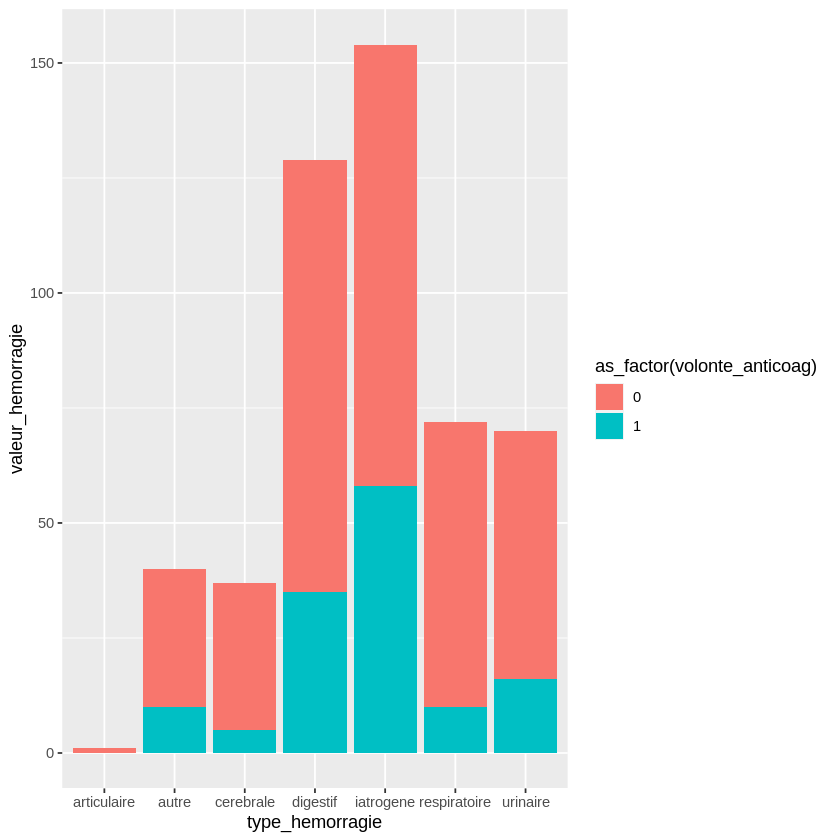

In [32]:
sejours_rea_48_heures %>%
    select(starts_with("hemorragie"), volonte_anticoag, patient_num, encounter_num) %>%
    collect() %>%
    anti_join(visites_avec_nc, by = "encounter_num") %>%
    select(-encounter_num) %>%
    pivot_longer(cols = starts_with("hemorragie"), names_to = "type_hemorragie", names_prefix = "hemorragie_", values_to = "valeur_hemorragie") %>%
    group_by(volonte_anticoag) %>%
    ggplot + geom_col(aes(x = type_hemorragie, y = valeur_hemorragie, fill = as_factor(volonte_anticoag)))

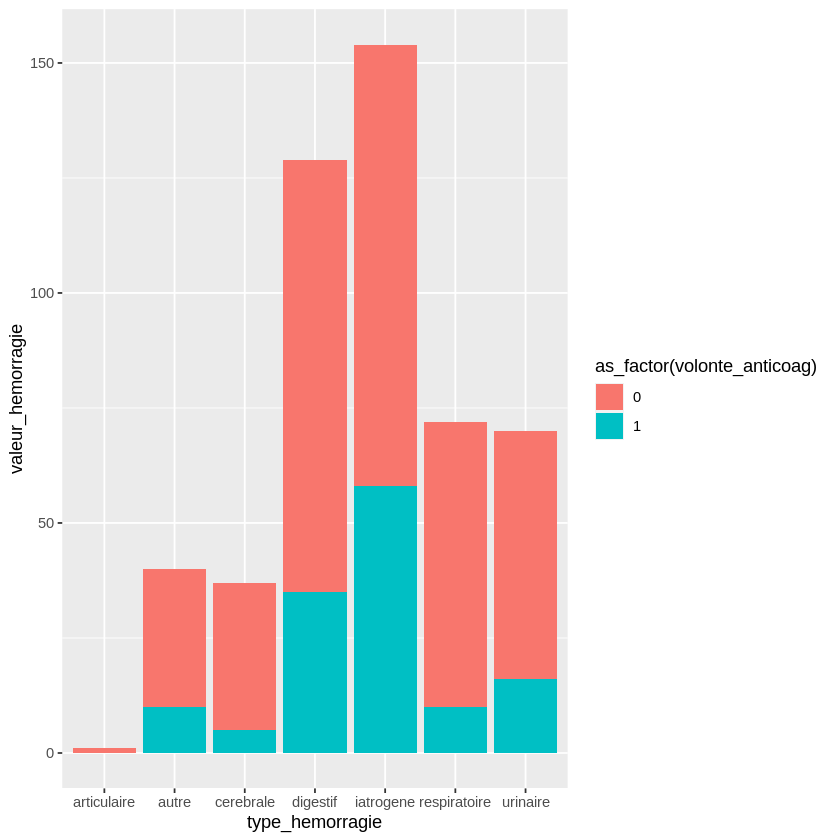

In [15]:
test %>%
    select(starts_with("hemorragie"), volonte_anticoag, patient_num, encounter_num) %>%
    collect() %>%
    anti_join(visites_avec_nc, by = "encounter_num") %>%
    select(-encounter_num) %>%
    pivot_longer(cols = starts_with("hemorragie"), names_to = "type_hemorragie", names_prefix = "hemorragie_", values_to = "valeur_hemorragie") %>%
    group_by(volonte_anticoag) %>%
    ggplot + geom_col(aes(x = type_hemorragie, y = valeur_hemorragie, fill = as_factor(volonte_anticoag)))

In [19]:
sejours_rea_48_heures %>%
    as_tibble() %>%
    group_by(volonte_anticoag) %>%
    count(hemorragie_cerebrale)

volonte_anticoag,hemorragie_cerebrale,n
<dbl>,<dbl>,<int>
0,0,3640
0,1,38
1,0,1279
1,1,5


In [21]:
sejours_rea_48_heures %>%
    as_tibble() %>%
    group_by(volonte_anticoag) %>%
    count(ischemie_cerebrale)

volonte_anticoag,ischemie_cerebrale,n
<dbl>,<dbl>,<int>
0,0,3605
0,1,73
1,0,1252
1,1,32


In [35]:
nb_patients_anticoag <- sejours_rea_48_heures %>%
    collect() %>%
    group_by(volonte_anticoag) %>%
    count()

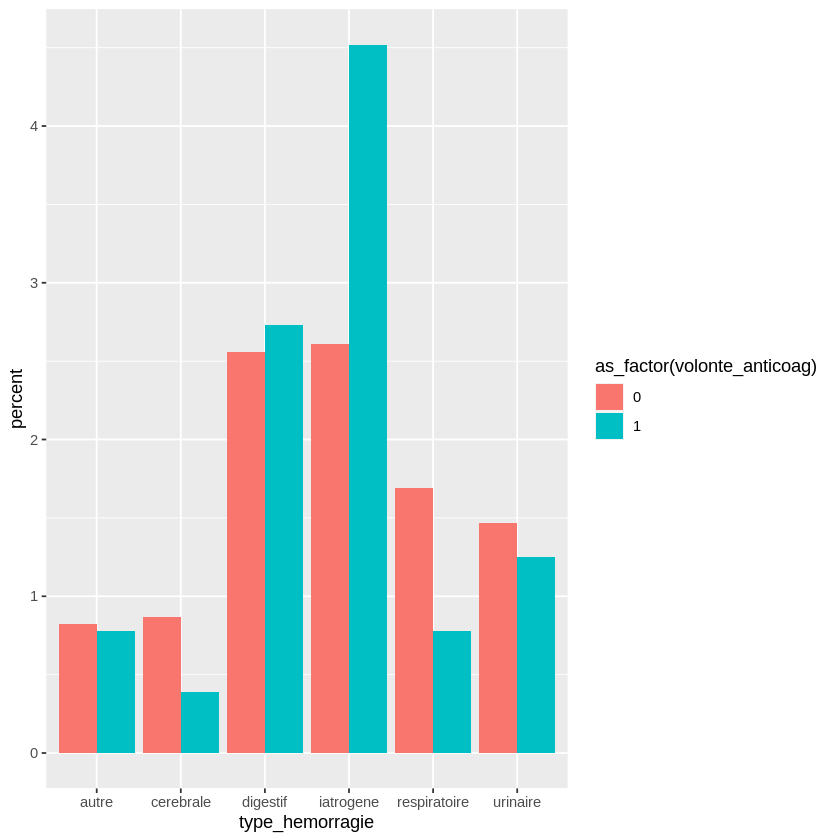

In [36]:
sejours_rea_48_heures %>%
    select(starts_with("hemorragie"), volonte_anticoag, patient_num, encounter_num) %>%
    collect() %>%
    anti_join(visites_avec_nc, by = "encounter_num") %>%
    select(-encounter_num) %>%
    pivot_longer(cols = starts_with("hemorragie"), names_to = "type_hemorragie", names_prefix = "hemorragie_", values_to = "valeur_hemorragie") %>%
    group_by(type_hemorragie, valeur_hemorragie, volonte_anticoag) %>%
    count() %>%
    left_join(nb_patients_anticoag, by = "volonte_anticoag") %>%
    filter(valeur_hemorragie == 1 && type_hemorragie != "articulaire") %>%
    mutate(percent = round(n.x/n.y*100, 2)) %>%
    ggplot() + geom_col(aes(x = type_hemorragie, y = percent, fill = as_factor(volonte_anticoag)), position = "dodge")

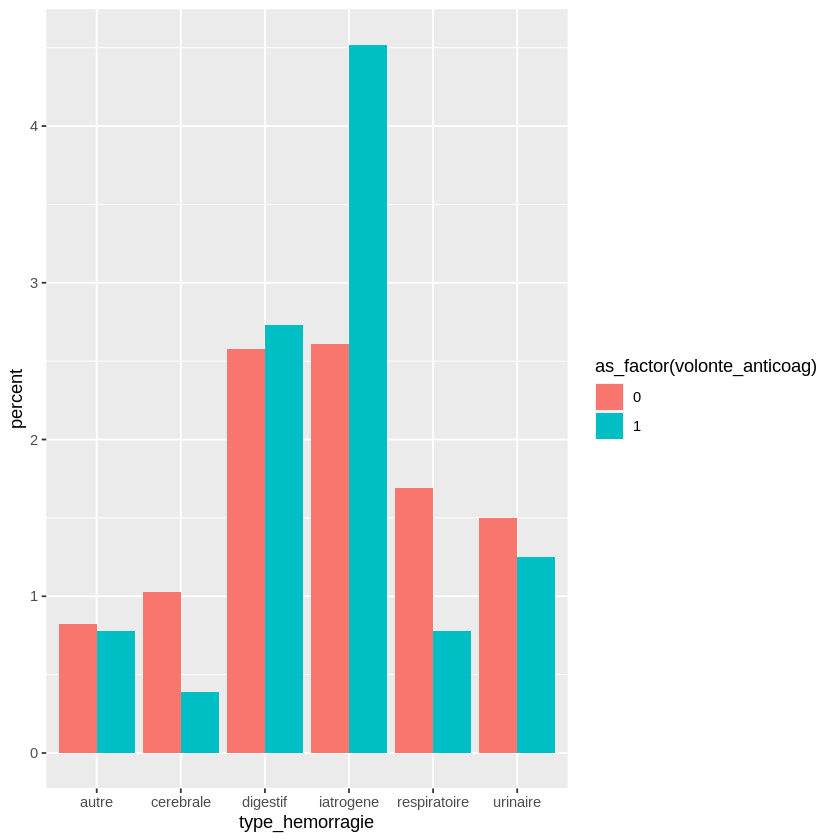

In [37]:
sejours_rea_48_heures %>%
    select(starts_with("hemorragie"), volonte_anticoag, patient_num) %>%
    collect() %>%
    pivot_longer(cols = starts_with("hemorragie"), names_to = "type_hemorragie", names_prefix = "hemorragie_", values_to = "valeur_hemorragie") %>%
    group_by(type_hemorragie, valeur_hemorragie, volonte_anticoag) %>%
    count() %>%
    left_join(nb_patients_anticoag, by = "volonte_anticoag") %>%
    filter(valeur_hemorragie == 1 && type_hemorragie != "articulaire") %>%
    mutate(percent = round(n.x/n.y*100, 2)) %>%
    ggplot() + geom_col(aes(x = type_hemorragie, y = percent, fill = as_factor(volonte_anticoag)), position = "dodge")

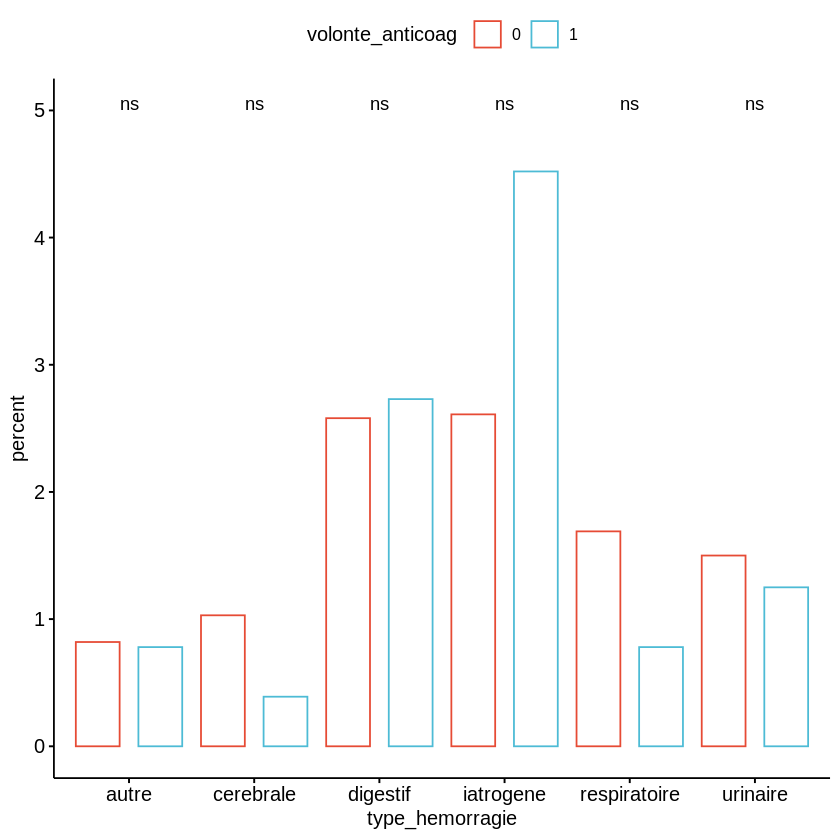

In [13]:
sejours_rea_48_heures %>%
    select(starts_with("hemorragie"), volonte_anticoag, patient_num) %>%
    collect() %>%
    pivot_longer(cols = starts_with("hemorragie"), names_to = "type_hemorragie", names_prefix = "hemorragie_", values_to = "valeur_hemorragie") %>%
    group_by(type_hemorragie, valeur_hemorragie, volonte_anticoag) %>%
    count() %>%
    left_join(nb_patients_anticoag, by = "volonte_anticoag") %>%
    filter(valeur_hemorragie == 1 && type_hemorragie != "articulaire") %>%
    mutate(percent = round(n.x/n.y*100, 2)) %>%
    mutate(volonte_anticoag = as_factor(volonte_anticoag)) %>%
    ggbarplot(x = "type_hemorragie", y = "percent", color = "volonte_anticoag",
              palette = "npg", position = position_dodge(1)) +
    stat_compare_means(aes(group = volonte_anticoag), label = "p.signif", label.y = 5)

In [14]:
nombre_codages_total_hors_dp <- sc %>% tbl('i2b2_observation_cim10') %>%
    filter(location_cd %in% liste_reas) %>%

# Filtre pour retirer les admissions dont le DP est l'événement ischémique
# Pourrait se discuter de l'enlever mais il est difficile de faire la différence entre une hospitalisation pour un événement hémorragique dont la cause est le traitement anticoagulant ou non
    filter(tval_char != "DP") %>%
    group_by(encounter_num) %>%
    collect() %>%
    count(concept_cd) %>%
    ungroup() %>%
    count(concept_cd) %>%
    summarise (nombre_codages_total_hors_dp = sum(n))

nombre_visites_rea <- sc %>% tbl('sejours_rea_48_heures') %>%
    collect() %>%
    count(encounter_num) %>%
    count()

nombre_patients_rea <- sc %>% tbl('sejours_rea_48_heures') %>%
    collect() %>%
    count(patient_num) %>%
    count()

In [28]:
grep

function (pattern, x, ignore.case = FALSE, perl = FALSE, value = FALSE, 
    fixed = FALSE, useBytes = FALSE, invert = FALSE) 
{
    if (!is.character(x)) 
        x <- structure(as.character(x), names = names(x))
    .Internal(grep(as.character(pattern), x, ignore.case, value, 
        perl, fixed, useBytes, invert))
}
<bytecode: 0x5625f3b15ab8>
<environment: namespace:base>

In [10]:
actes_ccam %>%
    collect() %>%
    filter(str_detect(concept_cd, "ACFA"))

patient_num,encounter_num,start_date_ccam,location_cd,concept_cd,instance_num,start_date_stay,end_date_stay
<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<dttm>,<dttm>
-4053480442676395889,-8809134055945286698,2019-02-27 23:00:00,UFR:010260,CCAM:ACFA002,6656152256,2019-02-27 11:15:00,2019-03-01 10:00:00


In [11]:
sc %>% tbl('i2b2_observation_ccam') %>%
    filter(concept_cd == "CCAM:AZQX005" | concept_cd == "CCAM:ACQP002") %>%
    filter(grep("ACFA", concept_cd)) %>%
    collect() %>%
    group_by(encounter_num) %>%
    count()

ERROR: Error: org.apache.spark.sql.AnalysisException: Undefined function: 'grep'. This function is neither a registered temporary function nor a permanent function registered in the database 'cse_200007_20210519'.; line 5 pos 7
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$15$$anonfun$applyOrElse$49.apply(Analyzer.scala:1281)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$15$$anonfun$applyOrElse$49.apply(Analyzer.scala:1281)
	at org.apache.spark.sql.catalyst.analysis.package$.withPosition(package.scala:53)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$15.applyOrElse(Analyzer.scala:1280)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$15.applyOrElse(Analyzer.scala:1272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$2.apply(TreeNode.scala:256)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$2.apply(TreeNode.scala:256)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:255)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$transformExpressionsDown$1.apply(QueryPlan.scala:83)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$transformExpressionsDown$1.apply(QueryPlan.scala:83)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$1.apply(QueryPlan.scala:105)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$1.apply(QueryPlan.scala:105)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpression$1(QueryPlan.scala:104)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.org$apache$spark$sql$catalyst$plans$QueryPlan$$recursiveTransform$1(QueryPlan.scala:116)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$2.apply(QueryPlan.scala:126)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.mapExpressions(QueryPlan.scala:126)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsDown(QueryPlan.scala:83)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressions(QueryPlan.scala:74)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveExpressions$1.applyOrElse(AnalysisHelper.scala:129)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveExpressions$1.applyOrElse(AnalysisHelper.scala:128)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1$$anonfun$2.apply(AnalysisHelper.scala:108)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1$$anonfun$2.apply(AnalysisHelper.scala:108)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1.apply(AnalysisHelper.scala:107)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1.apply(AnalysisHelper.scala:106)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:194)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperatorsDown(AnalysisHelper.scala:106)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDown(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1$$anonfun$apply$6.apply(AnalysisHelper.scala:113)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1$$anonfun$apply$6.apply(AnalysisHelper.scala:113)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:326)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:324)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1.apply(AnalysisHelper.scala:113)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsDown$1.apply(AnalysisHelper.scala:106)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:194)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperatorsDown(AnalysisHelper.scala:106)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDown(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperators(AnalysisHelper.scala:73)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperators(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveExpressions(AnalysisHelper.scala:128)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveExpressions(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$.apply(Analyzer.scala:1272)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$.apply(Analyzer.scala:1269)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:87)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:84)
	at scala.collection.IndexedSeqOptimized$class.foldl(IndexedSeqOptimized.scala:57)
	at scala.collection.IndexedSeqOptimized$class.foldLeft(IndexedSeqOptimized.scala:66)
	at scala.collection.mutable.WrappedArray.foldLeft(WrappedArray.scala:35)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:84)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:76)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:76)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:127)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:121)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$$anonfun$executeAndCheck$1.apply(Analyzer.scala:106)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$$anonfun$executeAndCheck$1.apply(Analyzer.scala:105)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:201)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:105)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:57)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:55)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:47)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:78)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:642)
	at sun.reflect.GeneratedMethodAccessor31.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at sparklyr.Invoke.invoke(invoke.scala:147)
	at sparklyr.StreamHandler.handleMethodCall(stream.scala:123)
	at sparklyr.StreamHandler.read(stream.scala:66)
	at sparklyr.BackendHandler.channelRead0(handler.scala:51)
	at sparklyr.BackendHandler.channelRead0(handler.scala:4)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:105)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:348)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:340)
	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102)
	at io.netty.channel.AbstractChannelHandlerContext.invo


In [25]:
# Répartition des types de codage uniques par visite

sc %>% tbl('i2b2_observation_cim10') %>%
    filter(location_cd %in% liste_reas) %>%
    collect() %>%
    group_by(encounter_num, tval_char) %>%
    count() %>%
    group_by(tval_char) %>%
    count()

tval_char,n
<chr>,<int>
DAD,202
DAS,9462
DP,9559
DR,75


In [19]:
# Représentation du nombre de visites en fonction du nombre de codages.

sc %>% tbl('i2b2_observation_cim10') %>%
    select(encounter_num, patient_num, concept_cd, tval_char, location_cd) %>%
    group_by(encounter_num) %>%
    distinct(.keep_all = TRUE) %>%
    collect() %>%
    count() 

n
<int>
978288


In [39]:
# DP des séjours de réa par ordres décroissants (ici groupés par visite avec DP distincts pour éliminer les séjours
# récurrents en réanimation pour le même motif)

dp_sejours_rea <- sc %>% tbl('i2b2_observation_cim10') %>%
    filter(location_cd %in% liste_reas) %>%
    filter(tval_char == "DP") %>%
    select(encounter_num, patient_num, concept_cd, start_date, instance_num, tval_char, location_cd) %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    select(-c(concept_cd, start_date, instance_num, tval_char)) %>%
    distinct() %>%
    right_join(sejours_rea_48_heures, by=c("encounter_num", "location_cd"))

In [53]:
dp_sejours_rea %>%
    collect() %>%
    group_by(encounter_num) %>%
    count() %>%
    filter(n == '2')%>%
    left_join(collect(sejours_rea_48_heures), by=c("encounter_num"))

encounter_num,n,location_cd,chads_vasc,patient_num,start_date_stay,end_date_stay,instance_num,vital_status_cd,birth_date,⋯,hemorragie_digestif,hemorragie_autre,hemorragie_iatrogene,hemorragie_articulaire,atcd_diabete,atcd_ins_renale,atcd_hta,atcd_ins_cardiaque,atcd_bpco,atcd_obesite
<chr>,<int>,<chr>,<dbl>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<dttm>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1002722231575613336,2,UFR:047242,1,9004420995909815814,2020-03-03 20:51:00,2020-03-06 21:26:00,9694591785,V,1931-11-29 00:00:00,⋯,0,0,0,0,0,0,0,0,0,0
-1010062224588108095,2,UFR:014025,4,418439950159638828,2017-05-01 13:06:00,2017-05-04 07:37:00,250686788,V,1946-03-25 23:00:00,⋯,0,0,0,0,0,0,1,1,1,1
-106321993993356333,2,UFR:011440,3,-785265122499598103,2019-05-23 14:24:00,2019-05-29 17:42:00,7357973910,D,1941-02-14 22:00:00,⋯,0,0,0,0,0,1,1,1,0,0
-1102119832537195245,2,UFR:026514,3,1195046223939767610,2018-09-16 06:46:00,2018-09-21 14:07:00,5298801306,D,1929-10-29 00:00:00,⋯,0,0,0,0,1,0,1,1,0,0
-1115300127364208383,2,UFR:095013,1,8938574749031091592,2016-11-19 09:03:00,2016-11-21 15:45:00,195449825,V,1987-09-07 22:00:00,⋯,0,0,0,0,1,0,0,0,0,0
-118443040103508886,2,UFR:087260,0,-1620206913199435347,2016-06-10 18:52:00,2016-07-13 13:22:00,158519281,V,1960-09-08 23:00:00,⋯,0,0,0,0,0,0,0,0,0,1
-122769249595613724,2,UFR:011440,2,-6721886952786672711,2019-12-19 10:23:00,2019-12-24 11:08:00,8775179489,V,1952-10-25 23:00:00,⋯,0,0,0,0,0,0,0,0,0,0
-125182392613472537,2,UFR:014025,4,998613553341323867,2020-07-22 10:02:00,2020-07-31 15:15:00,12735313631,V,1948-10-10 23:00:00,⋯,0,0,0,0,1,0,0,1,0,0
-1283098006805102598,2,UFR:095013,3,6363024924961888153,2016-06-29 16:00:00,2016-07-04 15:44:00,158399205,D,1946-09-01 23:00:00,⋯,0,0,0,0,1,1,1,0,0,0


In [43]:
dp_sejours_rea %>%
    as_tibble()

encounter_num,patient_num.x,location_cd,concept_cd_abr,chads_vasc,patient_num.y,start_date_stay,end_date_stay,instance_num,vital_status_cd,⋯,hemorragie_digestif,hemorragie_autre,hemorragie_iatrogene,hemorragie_articulaire,atcd_diabete,atcd_ins_renale,atcd_hta,atcd_ins_cardiaque,atcd_bpco,atcd_obesite
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dttm>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1940526645663244825,551636910350745347,UFR:028091,CIM10:N17,3,551636910350745347,2019-11-24 08:18:00,2019-11-26 23:51:00,8617816958,V,⋯,0,0,0,0,1,0,1,0,0,0
-3038322296693687105,-5993396861816493955,UFR:010260,CIM10:A41,2,-5993396861816493955,2020-01-15 16:07:00,2020-01-17 00:09:00,9014499469,V,⋯,0,0,0,0,0,0,1,0,0,1
-4405923021155085303,-4817315693073563125,UFR:068033,CIM10:U07,3,-4817315693073563125,2020-10-16 16:32:00,2020-10-20 15:47:00,14625839091,V,⋯,0,0,0,0,0,0,0,1,0,0
-4555196416114158492,-6713483261018835416,UFR:010030,CIM10:D76,1,-6713483261018835416,2016-11-13 14:53:00,2016-11-25 16:29:00,194587791,D,⋯,0,0,0,0,0,1,0,0,0,0
-4772485871535107629,9201225116227403215,UFR:087260,CIM10:J96,3,9201225116227403215,2017-11-13 12:48:00,2017-11-16 18:00:00,3080384000,D,⋯,0,0,0,0,0,0,0,1,0,0
-5637883353686037309,4227826860924843224,UFR:021034,CIM10:J93,2,4227826860924843224,2018-12-14 12:40:00,2018-12-24 17:24:00,6195555028,D,⋯,0,0,0,0,0,0,0,0,1,0
-5981677302362275123,5840944547972847330,UFR:011440,CIM10:K65,1,5840944547972847330,2019-11-20 12:21:00,2019-12-10 12:56:00,8617784537,D,⋯,0,0,0,0,0,0,0,0,0,0
-7348234114637942781,1669551821976146014,UFR:066420,CIM10:J96,3,1669551821976146014,2020-05-06 19:14:00,2020-05-07 20:21:00,11100418932,V,⋯,0,0,0,0,0,0,1,0,0,0
-7726385895311100291,6226830762466474137,UFR:073261,CIM10:Z48,0,6226830762466474137,2019-07-05 20:16:00,2019-07-08 10:10:00,7574747477,V,⋯,0,0,0,0,0,0,0,0,0,0


In [33]:
dp_sejours_rea_frequence <- dp_sejours_rea %>%
# groupés par visite
    group_by(encounter_num) %>%
    collect() %>%
    count(concept_cd_abr) %>%
# Somme des DP regroupés par visite
    ungroup() %>%
    count(concept_cd_abr) %>%
# Calcul du pourcentage
    mutate(percent = round(n * 100 / sum(n),2)) %>%
# Ordre décroissant
    arrange(desc(percent))

In [34]:
as_tibble(dp_sejours_rea_frequence)

# R57 choc non classé ailleurs
# Z48 Autres soins de contrôle chirurgicaux
# I50 Insuffisance cardiaque
# J96 Insuffisance respiratoire
# Z95 Implants et de greffes cardiaques et vasculaires (????)
# J15 Pneumopathies bactériennes
# J44 Autres maladies pulmonaires obstructives chroniques
# N17 Insuffisance rénale aiguë
# I46 Arrêt cardiaque
# A41 Autres sepsis
# U07 codage pour usage urgent
# K92 Autres maladies du système digestif
# I33 Endocardite aiguë et subaiguë
# I48 Fibrillation et flutter auriculaires
# R65 Syndrome de réponse inflammatoire systémique
# i71 Anévrisme aortique et dissection
# K65 Péritonite
# J69 Pneumopathie due à des substances solides et liquides
# E87 Autres déséquilibres hydro-électrolytiques et acido-basiques

concept_cd_abr,n,percent
<chr>,<int>,<dbl>
CIM10:A02,1,0.28
CIM10:A04,1,0.28
CIM10:A09,1,0.28
CIM10:A15,1,0.28
CIM10:A17,1,0.28
CIM10:A18,1,0.28
CIM10:A19,1,0.28
CIM10:A28,1,0.28
CIM10:A31,1,0.28


In [ ]:
# Somme des DP dont le pourcentage est > 1%

dp_sejours_rea_frequence %>%
    filter(percent > 1) %>%
    summarise(sum(percent))

In [ ]:
# DAS des séjours de réa par ordres décroissants (ici groupés par visite avec DP distincts pour éliminer les séjours
# récurrents en réanimation pour le même motif)

das_sejours_rea <- sc %>% tbl('i2b2_observation_cim10') %>%
    filter(location_cd %in% liste_reas) %>%
    filter(tval_char == "DAS") %>%
    select(encounter_num, patient_num, concept_cd, start_date, instance_num, tval_char, location_cd) %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    select(-c(concept_cd, start_date, instance_num, tval_char)) %>%
    distinct() %>%
    semi_join(sejours_rea_48_heures, by=c("encounter_num", "location_cd"))

In [ ]:
das_sejours_rea %>%
    group_by(encounter_num) %>%
    count() %>% count() %>%
    as_tibble()

Que faire de ces multiples séjours USC / Réa, où, pour l'instant, seul le premier est conservé ?
Je pense que ça modifie les données d'une façon importante (par exemple, s'il y a un AIC pendant les séjours
qu'on a choisi d'exclure)

010502 : USIP Bicêtre

010030 : Réa Med Bicêtre

010003 : Cardiologie Bicêtre

In [ ]:
sc %>% tbl('i2b2_observation_ufr') %>%
    filter(encounter_num == "-4749491545000345660") %>%
    select(encounter_num, patient_num, location_cd, start_date, end_date) %>%
    arrange(start_date) %>%
    as_tibble()

In [ ]:
das_sejours_rea_frequence <- das_sejours_rea %>%
# groupés par visite
    group_by(encounter_num) %>%
    count(concept_cd_abr) %>%
# Somme des DAS regroupés par visite
    ungroup() %>%
    count(concept_cd_abr) %>%
# Calcul du pourcentage
    mutate(percent = round(n * 100 / sum(n),2)) %>%
    filter (percent > 0) %>%
# Ordre décroissant
    arrange(desc(n))

In [ ]:
# DAS dont le pourcentage est > 1%
## dp_sejours_rea %>% summarise(sum(percent))

das_sejours_rea_frequence %>%
    filter(percent > 1) %>%
    arrange(desc(percent)) %>%
    as_tibble()

In [ ]:
# Somme des DP dont le pourcentage est > 1%

das_sejours_rea_frequence %>%
    filter(percent > 1) %>%
    summarise(sum(percent))

# Événements hémorragiques

ATTENTION ! CES TABLES EXPLORENT LES CODAGES SANS LES FILTRER AVEC LA TABLE DES SEJOURS SEJOURS_REA_48_HEURES

Il s'agit uniquement des codages pour les séjours en réanimation (basé sur l'UF, et pas sur l'ensembles des règles de filtrage issues du traitement initial des données

In [ ]:
# Par codage

codage_hemorragie <- sc %>% tbl('i2b2_observation_cim10') %>%
    filter(location_cd %in% liste_reas) %>%

# Filtre pour retirer les admissions dont le DP est l'événement
# Pourrait se discuter de l'enlever mais il est difficile de faire la différence entre une hospitalisation pour un événement hémorragique dont la cause est le traitement anticoagulant ou non
    filter(tval_char != "DP") %>%

# Collect() est nécessaire pour créer un objet local sans quoi str_detect ne peut être effectuée
# Filtre pour ne sélectionner que les codes des événements hémorragiques
# Regex_left_join permet de joindre les tables hemorragie et i2b2_observation_cim10 pour ajouter la colonne 'type' de l'hémorragie, en se basant sur une expression régulière (pour que I617 soit reconnu comme un saignement intracrânien)
# Création d'une nouvelle variable avec les codes abrégés (une lettre et deux chiffres) pour regrouper les événements en grandes classes

    collect() %>%
    filter(str_detect(concept_cd, paste(hemorragie$code, collapse = "|"))) %>%
    regex_left_join(hemorragie, by = c(concept_cd = "code")) %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    mutate(type_rea = ifelse(location_cd %in% liste_reas_med, 'med', 'chir'))

In [ ]:
codage_hemorragie %>%

# Ne pas doublonner les diagnostics qui ont été codés sur plusieurs séjours de la même visite
# Ne me semble pas pertinent de le retirer, même s'il est possible qu'un certain nombre de complications identiques au cours de la même visite (ex : deux hématomes du psoas consécutifs), ne soient pas comptabilisés.
    group_by(encounter_num, type_rea) %>%

# Compte du nombre de codes par visite
    count(concept_cd_abr) %>%
    ungroup() %>%
    group_by(type_rea) %>%

# Compte du nombre de codes au total
    count(concept_cd_abr) %>%

# Mutate pour créer trois pourcentages : celui par rapport aux événements ischémiques, un autre par rapport à l'ensemble des codes uniques (par visite), un autre par rapport au nombre de visites
    mutate(percent_events = round(n * 100 / sum(n), 2)) %>%
    mutate(percent_codes = round(n * 100 / nombre_codages_total_hors_dp[[1]], 2)) %>%
    mutate(percent_visit = round(n * 100 / nombre_visites_rea[[1]], 2)) %>%

# Tri décroissant
    arrange(desc(n))

In [ ]:
# Par localisation hémorragique

codage_hemorragie %>%

# Ne pas doublonner les diagnostics qui ont été codés sur plusieurs séjours de la même visite
# Ne me semble pas pertinent de le retirer, même s'il est possible qu'un certain nombre de complications identiques au cours de la même visite (ex : deux hématomes du psoas consécutifs), ne soient pas comptabilisés.
    group_by(encounter_num, type) %>%

# Compte du nombre de codes par visite
    count(concept_cd_abr) %>%
    ungroup() %>%
    group_by(type) %>%

# Compte du nombre de codes au total
    count(concept_cd_abr) %>%

# Compte du nombre de codes par type de localisation hémorragique
    ungroup() %>%
    group_by(type) %>%
    summarise(nombre = sum(n), .groups = 'drop') %>%

# Mutate pour créer trois pourcentages : celui par rapport aux événements ischémiques, un autre par rapport à l'ensemble des codes uniques (par visite), un autre par rapport au nombre de visites
    mutate(percent_events = round(nombre * 100 / sum(nombre), 2)) %>%
    mutate(percent_codes = round(nombre * 100 / nombre_codages_total_hors_dp[[1]], 2)) %>%
    mutate(percent_visit = round(nombre * 100 / nombre_visites_rea[[1]], 2)) %>%

# Tri décroissant
    arrange(type, desc(nombre))

In [ ]:
codage_hemorragie %>%

# Ne pas doublonner les diagnostics qui ont été codés sur plusieurs séjours de la même visite
# Ne me semble pas pertinent de le retirer, même s'il est possible qu'un certain nombre de complications identiques au cours de la même visite (ex : deux hématomes du psoas consécutifs), ne soient pas comptabilisés.
    group_by(encounter_num, type) %>%

# Compte du nombre de codes par visite
    count(concept_cd_abr) %>%
    ungroup() %>%
    group_by( type) %>%

# Compte du nombre de codes au total
    count(concept_cd_abr) %>%

# Compte du nombre de codes par type de localisation hémorragique
    ungroup() %>%
    group_by(type) %>%
    summarise(nombre = sum(n), .groups = 'drop') 

In [ ]:
# Codages d'anémies post-hémorragiques (D62)

codage_hemorragie %>%

# Ne pas doublonner les diagnostics qui ont été codés sur plusieurs séjours de la même visite
# Ne me semble pas pertinent de le retirer, même s'il est possible qu'un certain nombre de complications identiques au cours de la même visite (ex : deux hématomes du psoas consécutifs), ne soient pas comptabilisés.
    group_by(encounter_num) %>%

# Compte du nombre de codes par visite
    count(type) %>%
    ungroup() %>%

# Compte du nombre de codes au total
    count(type) %>%

# Mutate pour créer deux pourcentages : celui par rapport aux événements ischémiques, un autre par rapport à l'ensemble des codes uniques (par visite), un autre par rapport au nombre de visites
    mutate(percent_codes = round(n * 100 / nombre_codages_total_hors_dp[[1]], 2)) %>%
    mutate(percent_visit = round(n * 100 / nombre_visites_rea[[1]], 2)) %>%

# Tri décroissant
    arrange(desc(n))

# Événements ischémiques

In [ ]:
codage_ischemie <- sc %>% tbl('i2b2_observation_cim10') %>%
    filter(location_cd %in% liste_reas) %>%

# Filtre pour retirer les admissions dont le DP est l'événement ischémique
# Pourrait se discuter de l'enlever mais il est difficile de faire la différence entre une hospitalisation pour un événement hémorragique dont la cause est le traitement anticoagulant ou non
    filter(tval_char != "DP") %>%

# Collect() est nécessaire pour créer un objet local sans quoi str_detect ne peut être effectuée
# Filtre pour ne sélectionner que les codes des événements hémorragiques
# Regex_left_join permet de joindre les tables hemorragie et i2b2_observation_cim10 pour ajouter la colonne 'type' de l'hémorragie, en se basant sur une expression régulière (pour que I631 soit reconnues comme une ischémie cérébrale)
# Création d'une nouvelle variable avec les codes abrégés (une lettre et deux chiffres) pour regrouper les événements en grandes classes
    
    collect() %>%
    filter(str_detect(concept_cd, paste(ischemie$code, collapse = "|"))) %>%
    regex_left_join(ischemie, by = c(concept_cd = "code")) %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    mutate(type_rea = ifelse(location_cd %in% liste_reas_med, 'med', 'chir'))

In [ ]:
codage_ischemie %>%

# Ne pas doublonner les diagnostics qui ont été codés sur plusieurs séjours de la même visite
# Ne me semble pas pertinent de le retirer, même s'il est possible qu'un certain nombre de complications identiques au cours de la même visite (ex : deux hématomes du psoas consécutifs), ne soient pas comptabilisés.
    group_by(encounter_num, type) %>%

# Compte du nombre de codes par visite
    count(concept_cd_abr) %>%
    ungroup() %>%
    group_by( type) %>%

# Compte du nombre de codes au total
    count(concept_cd_abr) %>%
    ungroup() %>%

# Mutate pour créer trois pourcentages :0 celui par rapport aux événements ischémiques, un autre par rapport à l'ensemble des codes uniques (par visite), un autre par rapport au nombre de visites
    mutate(percent_events = round(n * 100 / sum(n), 2)) %>%
    mutate(percent_codes = round(n * 100 / nombre_codages_total_hors_dp[[1]], 2)) %>%
    mutate(percent_visit = round(n * 100 / nombre_visites_rea[[1]], 2)) %>%

# Tri décroissant
    arrange(type, desc(n))

In [ ]:
codage_ischemie %>%

# Ne pas doublonner les diagnostics qui ont été codés sur plusieurs séjours de la même visite
# Ne me semble pas pertinent de le retirer, même s'il est possible qu'un certain nombre de complications identiques au cours de la même visite (ex : deux hématomes du psoas consécutifs), ne soient pas comptabilisés.
    group_by(encounter_num, type) %>%

# Compte du nombre de codes par visite
    count(concept_cd_abr) %>%
    ungroup() %>%
    group_by(type) %>%

# Compte du nombre de codes au total
    count(concept_cd_abr) %>%
    ungroup() %>%

# Graphique
    ggplot() + geom_col(aes(reorder(x = type, -n), y =  n))

In [ ]:
codage_ischemie %>%

### Je doute de la qualité méthodologie de ce graphique qui n'est pas très intéressant je pense. 
### D'abord parce qu'il n'y a pas de normalisation des AIC en fonction de l'efficacité de l'anticoagulation sur la proportion de patients effectivement correctement anticoagulés.
### Ensuite parce qu'il s'agit de prendre la cohorte de patients ayant fait des AIC et de regarder leur anticoagulation, alors qu'il semble plus logique de faire l'inverse
### à savoir prendre une exposition (ici l'anticoagulation)

    filter(concept_cd_abr == 'CIM10:I63') %>%
    left_join(donnees_aggregees_filtrees_anticoag, by = 'encounter_num', copy = TRUE) %>%
    glimpse()

In [ ]:
codage_ischemie %>%

### Je doute de la qualité méthodologie de ce graphique qui n'est pas très intéressant je pense. 
### D'abord parce qu'il n'y a pas de normalisation des AIC en fonction de l'efficacité de l'anticoagulation sur la proportion de patients effectivement correctement anticoagulés.
### Ensuite parce qu'il s'agit de prendre la cohorte de patients ayant fait des AIC et de regarder leur anticoagulation, alors qu'il semble plus logique de faire l'inverse
### à savoir prendre une exposition (ici l'anticoagulation)

    filter(concept_cd_abr == 'CIM10:I63') %>%
    left_join(donnees_aggregees_filtrees_anticoag, by = 'encounter_num', copy = TRUE) %>%
    mutate(efficacite_anticoag = factor(efficacite_anticoag)) %>%
    mutate(type_anticoag = factor(type_anticoag)) %>%
    mutate(volonte_anticoag = factor(volonte_anticoag)) %>%
    select(encounter_num, concept_cd_abr, efficacite_anticoag, volonte_anticoag) %>%
    distinct() %>%
    ggplot() + geom_bar(aes(x=volonte_anticoag, fill=efficacite_anticoag))